# import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf


C:\Users\Anonymous\AppData\Local\Temp\ipykernel_18376\2551180754.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data=pd.read_csv('datasets/INFY20002008.csv')


# selecting input column

In [3]:
print(data.columns)
data1=data[['Last Price','Average Price','Open Price']].values
print(data1)

Index(['Unnamed: 0', 'Symbol', 'Series', 'Date', 'Prev Close', 'Open Price',
       'High Price', 'Low Price', 'Last Price', 'Close Price', 'Average Price',
       'Total Traded Quantity', 'Turnover', 'No. of Trades', 'Deliverable Qty',
       '% Dly Qt to Traded Qty'],
      dtype='object')
[[15625.2  15625.18 15625.  ]
 [16875.25 16646.38 16800.  ]
 [15507.45 15786.38 15701.  ]
 ...
 [ 2576.8   2576.34  2595.1 ]
 [ 2576.    2594.45  2567.1 ]
 [ 2604.7   2599.94  2585.  ]]


# plot the grapth with these 3 columns

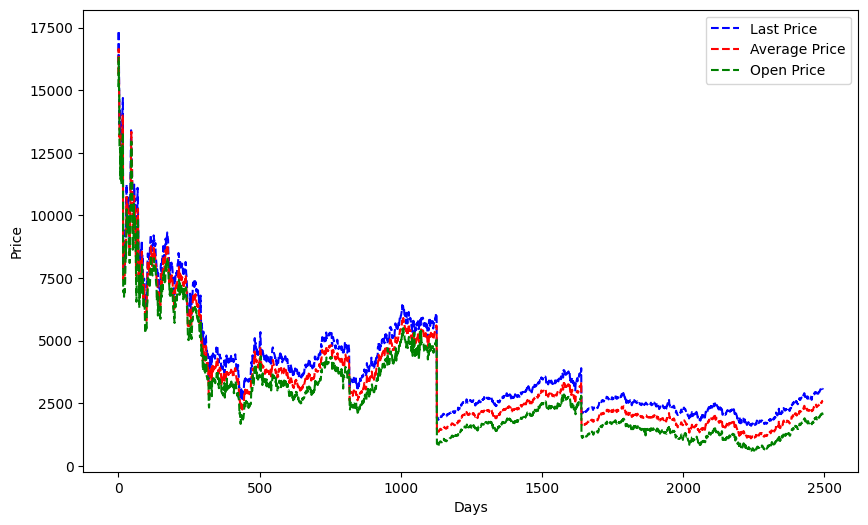

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data1[:,0]+500, '--b', label='Last Price')
plt.plot(data1[:,1],'--r',label='Average Price')
plt.plot(data1[:,2]-500,'--g',label='Open Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# normalize the data

In [5]:
scalar=MinMaxScaler()
x_data=scalar.fit_transform(data1)
x_data

array([[0.92076381, 0.93435567, 0.92514493],
       [1.        , 1.        , 1.        ],
       [0.91330006, 0.94471786, 0.92998662],
       ...,
       [0.09367245, 0.09555583, 0.09505638],
       [0.09362174, 0.09671997, 0.0932726 ],
       [0.09544093, 0.09707287, 0.09441295]])

# split the dataset in the ratio 75:25 and train an LSTM model with four units 

In [6]:
train_size=int(x_data.shape[0]*0.75)
x_train,x_test=x_data[0:train_size,:],x_data[int(x_data.shape[0]*0.75):,]
print(len(x_train),x_test.shape)
print("Number of entries (training set, test set): " + str((len(x_train), len(x_test))))

1872 (624, 3)
Number of entries (training set, test set): (1872, 624)


In [7]:
def create_dataset(series,window=1):
    x_data,y_data=[],[]
    for i in range(len(series)-window-1):
        a=[]
        for j in range(0,window):
            a.append(series[[i+j],:])
        x_data.append(a)
        y_data.append(series[i+window,1])
    return(np.array(x_data),np.array(y_data))
window=50
xtrain,ytrain=create_dataset(x_train,window)
xtest,ytest=create_dataset(x_test,window)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

#reshape
xtrain=np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],3))
xtest=np.reshape(xtest,(xtest.shape[0],xtest.shape[1],3))
print(xtrain.shape,xtest.shape)

(1821, 50, 1, 3) (1821,) (573, 50, 1, 3) (573,)
(1821, 50, 3) (573, 50, 3)


# build the model

In [8]:
model=Sequential([
    keras.layers.GRU(4,input_shape=(50,3)),
    keras.layers.Dense(1)
])
model.summary()
model.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(),metrics=['accuracy'])
model.fit(xtrain,ytrain,epochs=3,batch_size=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4)                 108       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1821/1821 [==============================] - 19s 6ms/step - loss: 0.0021 - accuracy: 0.0000e+00
Epoch 2/3
1821/1821 [==============================] - 11s 6ms/step - loss: 2.4432e-04 - accuracy: 0.0000e+00
Epoch 3/3
1821/1821 [==============================] - 11s 6ms/step - loss: 2.2393e-04 - accuracy: 0.0000e+00


# visualization and prediction 

18/18 [==============================] - 0s 3ms/step


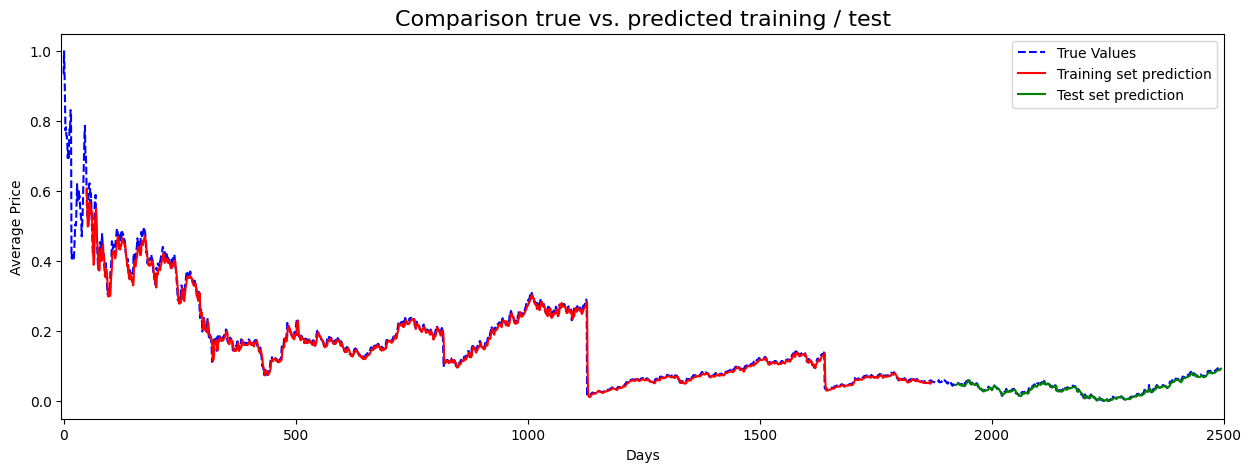

In [9]:
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((x_train[:,1],x_test[:,1])),'--b',label='True Values')
plt.plot(range(window,len(xtrain)+window),model.predict(xtrain),'-r',label='Training set prediction')
plt.plot(range(window+len(x_train),len(x_train)+len(x_test)-1),model.predict(xtest),'-g',label='Test set prediction')
plt.xlabel("Days")
plt.ylabel("Average Price")
plt.title("Comparison true vs. predicted training / test", fontsize=16)
plt.legend()
plt.xlim(-5, 2500)
plt.show()